### code to calculate binning in z and theta

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40771,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:36211,Total threads: 2
Dashboard: /proxy/34017/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:33299,


In [3]:
# files:
base = '/g/data/e14/rmh561/access-om2/archive/025deg_jra55_ryf_norediGM/';
xch = 1440#2*288
ych = 1080#2*216

fgrd   = xr.open_dataset(base + 'output086/ocean/ocean_grid.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch,'xu_ocean':xch})
output = 'output086-094_mean'
fwmass_sc = xr.open_mfdataset(base + output + '/ocean_wmass.ncea.nc').chunk({'time': 1,'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch})
fmonth_sc = xr.open_mfdataset(base + output + '/ocean_month.ncea.nc').chunk({'time': 1,'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch})
fheat_sc  = xr.open_mfdataset(base + output + '/ocean_heat.ncea.nc').chunk({'time': 1,'yt_ocean':ych,'xt_ocean':xch})
fwmass_mean = xr.open_mfdataset(base + output + '/ocean_wmass.ncea.ncra.nc').chunk({'grid_yt_ocean':ych,'grid_yu_ocean':ych,'grid_xt_ocean':xch}).isel(time=0)
fmonth_mean = xr.open_mfdataset(base + output + '/ocean_month.ncea.ncra.nc').chunk({'yt_ocean':ych,'yu_ocean':ych,'xt_ocean':xch}).isel(time=0)
fheat_mean = xr.open_mfdataset(base + output + '/ocean_heat.ncea.ncra.nc').chunk({'yt_ocean':ych,'xt_ocean':xch}).isel(time=0)

# Generate xgcm grid object:
gridwm = Grid(fwmass_mean,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_mean,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_mean,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_mean.neutral[1]-fwmass_mean.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extrapolate').rename({'yt_ocean':'grid_yt_ocean'})

In [4]:
# Group SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP

# Group SF and MX terms:
fwmass_sc["SF_cv"] = fwmass_sc.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_sc.sfc_hflux_pme_on_nrho + \
                       fwmass_sc.frazil_on_nrho + \
                       fwmass_sc.sw_heat_on_nrho# + \
#                       fwmass_sc.temp_rivermix_on_nrho
fwmass_sc["MX_cv"] = fwmass_sc.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_sc.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_sc.sfc_hflux_pme,fheat_sc.temp_vdiffuse_sbc)
sfc_hflux_pme_sc = obj.where(fheat_sc.st_ocean==fheat_sc.st_ocean[0],other=0.)

fheat_sc["SF_cv"] = fheat_sc.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_sc + \
                      fheat_sc.frazil_3d + \
                      fheat_sc.sw_heat# + \
#                      fheat_sc.temp_rivermix
fheat_sc["MX_cv"] = fheat_sc.temp_vdiffuse_diff_cbt + \
                      fheat_sc.temp_nonlocal_KPP 

In [5]:
theta_bin_edges = fwmass_mean.neutralrho_edges.values+273.15
theta_bin_edges


array([270.15, 270.65, 271.15, 271.65, 272.15, 272.65, 273.15, 273.65,
       274.15, 274.65, 275.15, 275.65, 276.15, 276.65, 277.15, 277.65,
       278.15, 278.65, 279.15, 279.65, 280.15, 280.65, 281.15, 281.65,
       282.15, 282.65, 283.15, 283.65, 284.15, 284.65, 285.15, 285.65,
       286.15, 286.65, 287.15, 287.65, 288.15, 288.65, 289.15, 289.65,
       290.15, 290.65, 291.15, 291.65, 292.15, 292.65, 293.15, 293.65,
       294.15, 294.65, 295.15, 295.65, 296.15, 296.65, 297.15, 297.65,
       298.15, 298.65, 299.15, 299.65, 300.15, 300.65, 301.15, 301.65,
       302.15, 302.65, 303.15, 303.65, 304.15, 304.65, 305.15, 305.65,
       306.15, 306.65, 307.15])

In [6]:
theta_bins = fwmass_mean.neutral.values+273.15
theta_bins

array([270.4, 270.9, 271.4, 271.9, 272.4, 272.9, 273.4, 273.9, 274.4,
       274.9, 275.4, 275.9, 276.4, 276.9, 277.4, 277.9, 278.4, 278.9,
       279.4, 279.9, 280.4, 280.9, 281.4, 281.9, 282.4, 282.9, 283.4,
       283.9, 284.4, 284.9, 285.4, 285.9, 286.4, 286.9, 287.4, 287.9,
       288.4, 288.9, 289.4, 289.9, 290.4, 290.9, 291.4, 291.9, 292.4,
       292.9, 293.4, 293.9, 294.4, 294.9, 295.4, 295.9, 296.4, 296.9,
       297.4, 297.9, 298.4, 298.9, 299.4, 299.9, 300.4, 300.9, 301.4,
       301.9, 302.4, 302.9, 303.4, 303.9, 304.4, 304.9, 305.4, 305.9,
       306.4, 306.9])

initialise empty arrays of desired coordinates

In [7]:
sf_binned = xr.DataArray(np.zeros((len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_mean.st_ocean, theta_bins],
                                               dims = ['st_ocean', 'theta_bins'],
                                               name = 'sf_binned')
mx_binned = xr.DataArray(np.zeros((len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_mean.st_ocean, theta_bins],
                                               dims = ['st_ocean', 'theta_bins'],
                                               name = 'mx_binned')

In [32]:
for i in range(len(theta_bins)):
    print(i)
    #create masks for isopycnal binnning, that are 1 where the density that day is between two bin values, and 0 elsewhere
    bin_mask = fmonth_mean.temp.where(fmonth_mean.temp<=theta_bin_edges[i+1]).where(fmonth_mean.temp>theta_bin_edges[i])*0+1
    SF_in_bin = (fheat_mean.SF_cv * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    sf_binned[:,i] += SF_in_bin
    MX_in_bin = (fheat_mean.MX_cv * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    mx_binned[:,i] += MX_in_bin

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


In [33]:
mask_temp = fmonth_mean.temp.max('xt_ocean').max('yt_ocean')

## to get heat flux - do you accumulate in vertical direction or temperature? heat convergence data is from x,y,z so I guess z?

(200.0, 0.0)

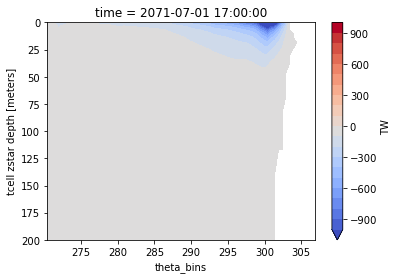

In [44]:
((sf_binned.cumsum('st_ocean')-sf_binned.sum('st_ocean'))/1e12).where(sf_binned.theta_bins <mask_temp).plot.contourf(cmap = 'coolwarm', levels = np.arange(-1000,1001,100), cbar_kwargs={'label':'TW'})
plt.ylim(200,0)

(200.0, 0.0)

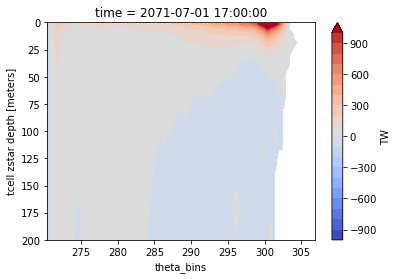

In [45]:
((mx_binned.cumsum('st_ocean')-mx_binned.sum('st_ocean'))/1e12).where(mx_binned.theta_bins <mask_temp).plot.contourf(cmap = 'coolwarm', levels = np.arange(-1000,1001,100),cbar_kwargs={'label':'TW'})
plt.ylim(200,0)

In [7]:
# load RYF daily data
#### load output of monthly data for 8 years (RYF) #### output 086-094
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'output095/ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'output095/ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'output095/ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

obj, obj2 = xr.broadcast(fheat_daily.sfc_hflux_pme,fheat_daily.temp_vdiffuse_sbc)
sfc_hflux_pme_daily = obj.where(fheat_daily.st_ocean==fheat_daily.st_ocean[0],other=0.)

fheat_daily["MX_cv"] = fheat_daily.temp_vdiffuse_diff_cbt + \
                      fheat_daily.temp_nonlocal_KPP 
fheat_daily["SF_cv"] = fheat_daily.temp_vdiffuse_sbc + \
                      fheat_daily.sw_heat + \
                      fheat_daily.frazil_3d + sfc_hflux_pme_daily 
#                      fheat_sc.temp_rivermix

In [8]:
# load RYF monthly data
#### load output of monthly data for 8 years (RYF) #### output 086-094
base_msc = '/scratch/e14/cy8964/access-om2/archive/025deg_jra55_ryf/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'output095/ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'output095/ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'output095/ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})
fsnap_m = xr.open_mfdataset(base_msc+'output095/ocean/ocean_snap.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})

obj, obj2 = xr.broadcast(fheat_m.sfc_hflux_pme,fheat_m.temp_vdiffuse_sbc)
sfc_hflux_pme_m = obj.where(fheat_m.st_ocean==fheat_m.st_ocean[0],other=0.)

fheat_m["SF_cv"] = fheat_m.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_m + \
                      fheat_m.frazil_3d + \
                      fheat_m.sw_heat + \
                      fheat_m.temp_rivermix
fheat_m["MX_cv"] = fheat_m.temp_vdiffuse_diff_cbt + \
                      fheat_m.temp_nonlocal_KPP 


In [11]:
sf_binned = xr.DataArray(np.zeros((len(fmonth_m.time),len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_m.time,fmonth_mean.st_ocean, theta_bins],
                                               dims = ['time','st_ocean', 'theta_bins'],
                                               name = 'sf_binned')
mx_binned = xr.DataArray(np.zeros((len(fmonth_m.time),len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_m.time,fmonth_mean.st_ocean, theta_bins],
                                               dims = ['time','st_ocean', 'theta_bins'],
                                               name = 'mx_binned')
tendency_binned = xr.DataArray(np.zeros((len(fmonth_m.time),len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_m.time,fmonth_mean.st_ocean, theta_bins],
                                               dims = ['time','st_ocean', 'theta_bins'],
                                               name = 'tendency_binned')
adv_binned = xr.DataArray(np.zeros((len(fmonth_m.time),len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_m.time,fmonth_mean.st_ocean, theta_bins],
                                               dims = ['time','st_ocean', 'theta_bins'],
                                               name = 'adv_binned')
submeso_binned = xr.DataArray(np.zeros((len(fmonth_m.time),len(fmonth_mean.st_ocean),len(theta_bins))),
                                               coords = [fmonth_m.time,fmonth_mean.st_ocean, theta_bins],
                                               dims = ['time','st_ocean', 'theta_bins'],
                                               name = 'submeso_binned')

as for the time mean, but this does it for all times and keeps the time coordinate

In [13]:
for i in range(len(theta_bins)):
    print(i)
    #create masks for isopycnal binnning, that are 1 where the density that day is between two bin values, and 0 elsewhere
    bin_mask = fmonth_m.temp.where(fmonth_m.temp<=theta_bin_edges[i+1]).where(fmonth_m.temp>theta_bin_edges[i])*0+1
    # multiply values by mask, integrate in x and y direction
    SF_in_bin = (fheat_m.SF_cv * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    # add to xarray data array
    sf_binned[:,:,i] += SF_in_bin
    # same for MX
    MX_in_bin = (fheat_m.MX_cv * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    mx_binned[:,:,i] += MX_in_bin
    # same for temp tendency
    tendency_in_bin = (fheat_m.temp_tendency * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    tendency_binned[:,:,i] += tendency_in_bin
    # same for advection
    adv_in_bin = (fheat_m.temp_advection * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    adv_binned[:,:,i] += adv_in_bin
    # same for submeso advection
    submeso_in_bin = (fheat_m.temp_submeso * fgrd.area_t * bin_mask).sum('xt_ocean').sum('yt_ocean').fillna(0).values
    submeso_binned[:,:,i] += submeso_in_bin

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


2022-03-24 09:55:58,881 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


33


2022-03-24 09:56:17,191 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 09:56:21,545 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 09:56:43,118 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 09:56:59,532 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 09:57:12,123 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 09:57:24,690 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


34


2022-03-24 09:57:35,813 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:57:38,106 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:58:03,825 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:58:20,061 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:58:32,814 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:58:45,016 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


35


2022-03-24 09:58:56,533 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 09:58:59,232 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 09:59:23,218 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 09:59:39,473 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 09:59:51,490 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 10:00:04,573 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


36


2022-03-24 10:00:15,457 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:00:18,178 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 10:00:42,150 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 10:00:58,945 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-03-24 10:01:10,956 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:01:22,724 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


37


2022-03-24 10:01:33,367 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:01:36,084 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:02:00,099 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:02:13,677 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:02:28,074 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:02:40,138 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


38


2022-03-24 10:02:51,537 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-03-24 10:02:54,524 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:03:19,482 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:03:33,620 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:03:47,326 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:03:59,065 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


39


2022-03-24 10:04:10,021 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


40
41
42
43
44
45
46
47
48
49


2022-03-24 10:17:42,723 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:17:58,371 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-03-24 10:18:10,373 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


50


2022-03-24 10:18:21,216 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


51
52
53


KeyboardInterrupt: 

It stopped working here (went quite slowly and then got stuck on dask). But plotting the temperature bins it has done, it looks different to Abishek's paper. So maybe a mistake....

(5000.0, 0.0)

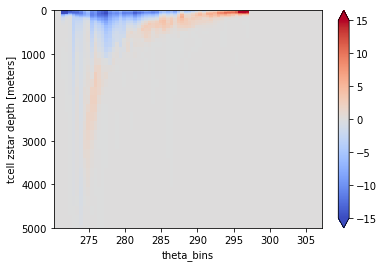

In [24]:
(((adv_binned+submeso_binned).mean('time').cumsum('st_ocean')-(adv_binned+submeso_binned).mean('time').sum('st_ocean'))/rho0/c_p/1e6).plot(cmap = 'coolwarm', vmin = -15, vmax = 15)
plt.ylim(5000,0)

(5000.0, 0.0)

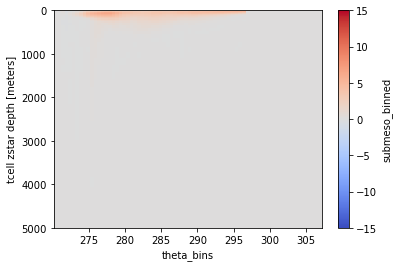

In [25]:
(((submeso_binned).mean('time').cumsum('st_ocean')-(submeso_binned).mean('time').sum('st_ocean'))/rho0/c_p/1e6).plot(cmap = 'coolwarm', vmin = -15, vmax = 15)
plt.ylim(5000,0)

(5000.0, 0.0)

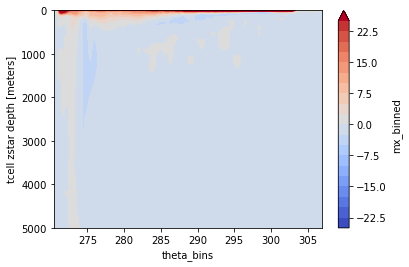

In [43]:
((mx_binned.mean('time').cumsum('st_ocean')-mx_binned.mean('time').sum('st_ocean'))/rho0/c_p/1e6).plot.contourf(cmap = 'coolwarm', vmin = -25, vmax = 25, levels = 21)
plt.ylim(5000,0)

(5000.0, 0.0)

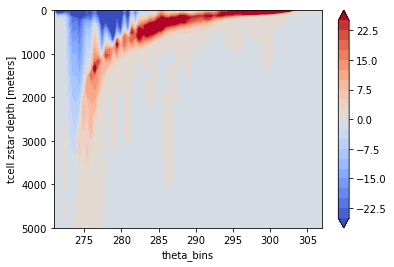

In [52]:
a = ((tendency_binned.mean('time').cumsum('st_ocean')-tendency_binned.mean('time').sum('st_ocean'))/1e6) - \
    ((sf_binned.mean('time').cumsum('st_ocean')-sf_binned.mean('time').sum('st_ocean'))/rho_0/c_p/1e6)- \
    ((mx_binned.mean('time').cumsum('st_ocean')-mx_binned.mean('time').sum('st_ocean'))/rho_0/c_p/1e6)

(a.cumsum('theta_bins')-a.sum('theta_bins')).diff('theta_bins').plot.contourf(cmap = 'coolwarm', vmin = -25, vmax = 25, levels = 21)
plt.ylim(5000,0)

In [62]:
fheat_m

,Array,Chunk
Bytes,6.95 GiB,5.93 MiB
Shape,"(12, 50, 1080, 1440)","(1, 50, 108, 144)"
Count,2413 Tasks,1200 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,6.95 GiB,5.93 MiB
Shape,"(12, 50, 1080, 1440)","(1, 50, 108, 144)"
Count,2413 Tasks,1200 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [ ]:
### save ##
# ds = xr.Dataset({'sf_binned': sf_binned, 'mx_binned': mx_binned, 'tendency_binned':tendency_binned})
# ds.to_netcdf('/scratch/e14/cy8964/temp/theta_z_binned_095_monthly.nc', 
#          encoding={'sf_binned': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                    'mx_binned': {'shuffle': True, 'zlib': True, 'complevel': 5},
#                    'tendency_binned': {'shuffle': True, 'zlib': True, 'complevel': 5}
#                   })